In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os, shutil

from fastai.vision import *
from fastai.widgets import ClassConfusion

In [3]:
path, dirs, files1 = os.walk("drive/My Drive/training/background").__next__()
path, dirs, files2 = os.walk("drive/My Drive/training/hi").__next__()
path, dirs, files3 = os.walk("drive/My Drive/training/test").__next__()

print("Number of images without text: {}".format(len(files1)),"Number of images with text: {}".format(len(files2)),"Number of images in test: {}".format(len(files3)) )

Number of images without text: 4450 Number of images with text: 1425 Number of images in test: 98


In [4]:
data = ImageDataBunch.from_folder('drive/My Drive/training/', train=".", valid_pct=0.25,test='test',
        ds_tfms=get_transforms(), bs=32, size=128, num_workers=4,).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  return _solve_func(B,A)[0][:,0]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/free

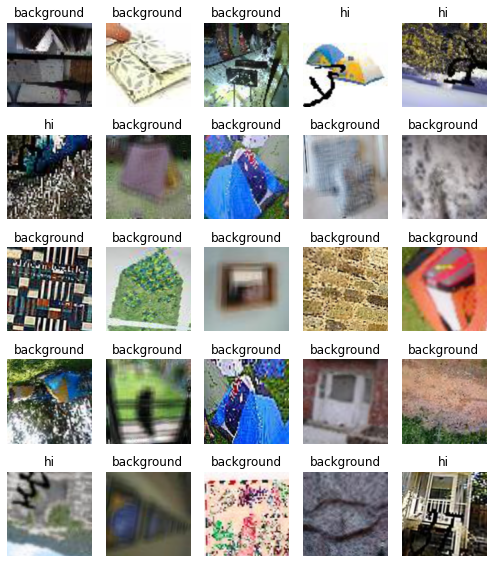

In [5]:
#sample of our images with labels
data.show_batch(rows=5, figsize=(7,8))

In [6]:
precision=Precision()
recall=Recall()
AUC=AUROC()

In [7]:
learn = cnn_learner(data, models.resnet101, metrics=(accuracy,precision,recall,AUC))

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2105837307351957717, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10738270208
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17298047515137349908
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [10]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.304855,0.158277,0.942779,0.950331,0.806180,0.969665,05:14


In [11]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.169821,0.112192,0.961853,0.968750,0.870786,0.991866,00:49
1,0.111386,0.099281,0.963896,0.987138,0.862360,0.993028,00:49


In [12]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


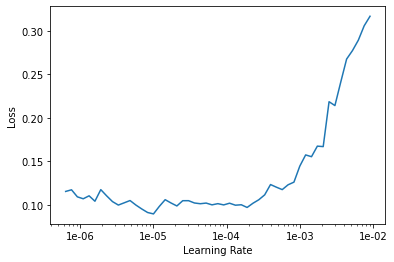

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(15, max_lr=slice(8e-04,1e-03))

epoch,train_loss,valid_loss,accuracy,precision,recall,auroc,time
0,0.104704,0.082397,0.974796,0.984802,0.910112,0.988501,01:08
1,0.109954,0.508605,0.967984,0.891139,0.988764,0.993997,01:08
2,0.151294,0.104102,0.961853,0.888601,0.963483,0.995372,01:08
3,0.128151,0.072846,0.977520,0.962751,0.943820,0.996986,01:08
4,0.133336,0.079695,0.972071,0.948718,0.935393,0.995592,01:07
5,0.116965,0.064438,0.977520,1.000000,0.907303,0.996158,01:07
6,0.090234,0.074011,0.971390,0.928962,0.955056,0.996095,01:08
7,0.082969,0.071241,0.972752,0.920213,0.971910,0.996888,01:08
8,0.090842,0.052573,0.980245,1.000000,0.918539,0.998979,01:08
9,0.057403,0.018794,0.995232,1.000000,0.980337,0.999778,01:08


In [22]:
learn.save('nvidia_modelResNet101_stage1')

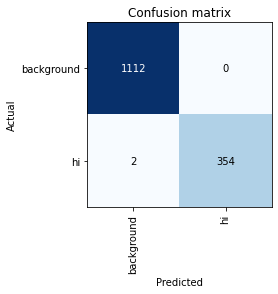

In [23]:
#confusion matrix for the first 2 iterations
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [24]:
cat, tensor, probs = learn.predict(open_image(f"drive/My Drive/training/test/1.jpg"))

In [25]:
tensor

tensor(1)

In [26]:
import random
import json
import glob

In [27]:
def write_json(filename, result):
    with open(filename, 'w') as outfile:
        json.dump(result, outfile)

def read_json(filename):
    with open(filename, 'r') as outfile:
        data =  json.load(outfile)
    return data


In [32]:
def generate_results(filename):
    res = {}
    for i in range(1,99):
        test_set = str(i) + '.jpg'
        name ="drive/My Drive/training/test/"+test_set
        cat, tensor, probs = learn.predict(open_image(name))
        if tensor == 1:
          res[test_set] = 1
        else:
          res[test_set] = 0
    write_json(filename, res)


In [33]:
generate_results('./resnet101.json')